In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

In [2]:
df = pd.read_csv('/content/desertification_labeled.csv')

In [3]:
df['lc_type1'].value_counts()

,count
lc_type1,
40,74119
60,25380
50,17002
10,2850
80,2159
20,1559
90,682
30,248


In [4]:
df.sample().T

,45575
location_name,Dakahlia
year,2024
month,1
sand,358.0
silt,318.0
clay,324.0
soc,513.0
ph,72.0
bdod,129.0
cec,178.0


In [5]:
# drop location name, year, month
df.drop(['location_name', 'year', 'month'], axis=1, inplace=True)
#df.drop('location_name', axis=1, inplace=True)

In [6]:
df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123999 entries, 0 to 123998
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sand       123999 non-null  float64
 1   silt       123999 non-null  float64
 2   clay       123999 non-null  float64
 3   soc        123999 non-null  float64
 4   ph         123999 non-null  float64
 5   bdod       123999 non-null  float64
 6   cec        123999 non-null  float64
 7   ndvi       123999 non-null  float64
 8   t2m_c      123999 non-null  float64
 9   td2m_c     123999 non-null  float64
 10  rh_pct     123999 non-null  float64
 11  tp_m       123999 non-null  float64
 12  ssrd_jm2   123999 non-null  float64
 13  lc_type1   123999 non-null  int64  
 14  des_level  123999 non-null  object 
dtypes: float64(13), int64(1), object(1)
memory usage: 14.2+ MB


In [7]:
df.describe()

,sand,silt,clay,soc,ph,bdod,cec,ndvi,t2m_c,td2m_c,rh_pct,tp_m,ssrd_jm2,lc_type1
count,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,1.239990e+05,123999.000000
mean,410.967212,265.766631,299.772654,286.648553,74.187100,129.372421,176.186840,0.413166,22.595355,10.881446,48.653923,0.026975,9.427551e+09,45.475205
std,92.354598,57.265192,62.836355,160.485556,11.479854,21.829665,35.439703,0.211447,5.810962,4.738557,9.759863,0.043793,2.726709e+09,11.538169
min,34.700000,18.900000,17.900000,3.400000,7.100000,1.160000,1.280000,-0.114550,5.750651,-8.271046,12.078892,0.000124,4.024294e+08,10.000000
25%,363.000000,245.000000,268.000000,149.000000,73.000000,130.000000,166.000000,0.218900,17.542559,6.861911,42.102394,0.001804,6.478251e+09,40.000000
50%,402.000000,276.000000,299.000000,312.000000,75.000000,131.000000,186.000000,0.435800,22.738276,10.500346,49.620983,0.011162,9.761923e+09,40.000000
75%,471.000000,294.000000,345.000000,400.000000,79.000000,134.000000,194.000000,0.584650,28.116304,14.849731,55.768063,0.036230,1.215463e+10,50.000000
max,581.000000,425.000000,444.000000,821.000000,82.000000,150.000000,321.000000,0.884100,36.818349,22.776524,74.876660,1.476946,1.348570e+10,90.000000


In [8]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

In [9]:
def detect_outliers_iqr(data):
    outliers = {}
    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask = (data[col] < lower) | (data[col] > upper)
        outliers[col] = data[col][mask]
    return outliers

iqr_outliers = detect_outliers_iqr(df)

In [10]:
print("Outliers Detected Using IQR:")
for col, values in iqr_outliers.items():
    print(f"{col}: {len(values)} outliers")

Outliers Detected Using IQR:
sand: 3323 outliers
silt: 5617 outliers
clay: 3323 outliers
soc: 62 outliers
ph: 3323 outliers
bdod: 16622 outliers
cec: 3973 outliers
ndvi: 0 outliers
t2m_c: 0 outliers
td2m_c: 15 outliers
rh_pct: 224 outliers
tp_m: 9147 outliers
ssrd_jm2: 0 outliers
lc_type1: 7250 outliers


In [11]:
df['bdod'].value_counts()

,count
bdod,
130.00,19548
129.00,16320
131.00,15250
132.00,11533
133.00,9651
134.00,6894
128.00,5769
135.00,4223
140.00,3094


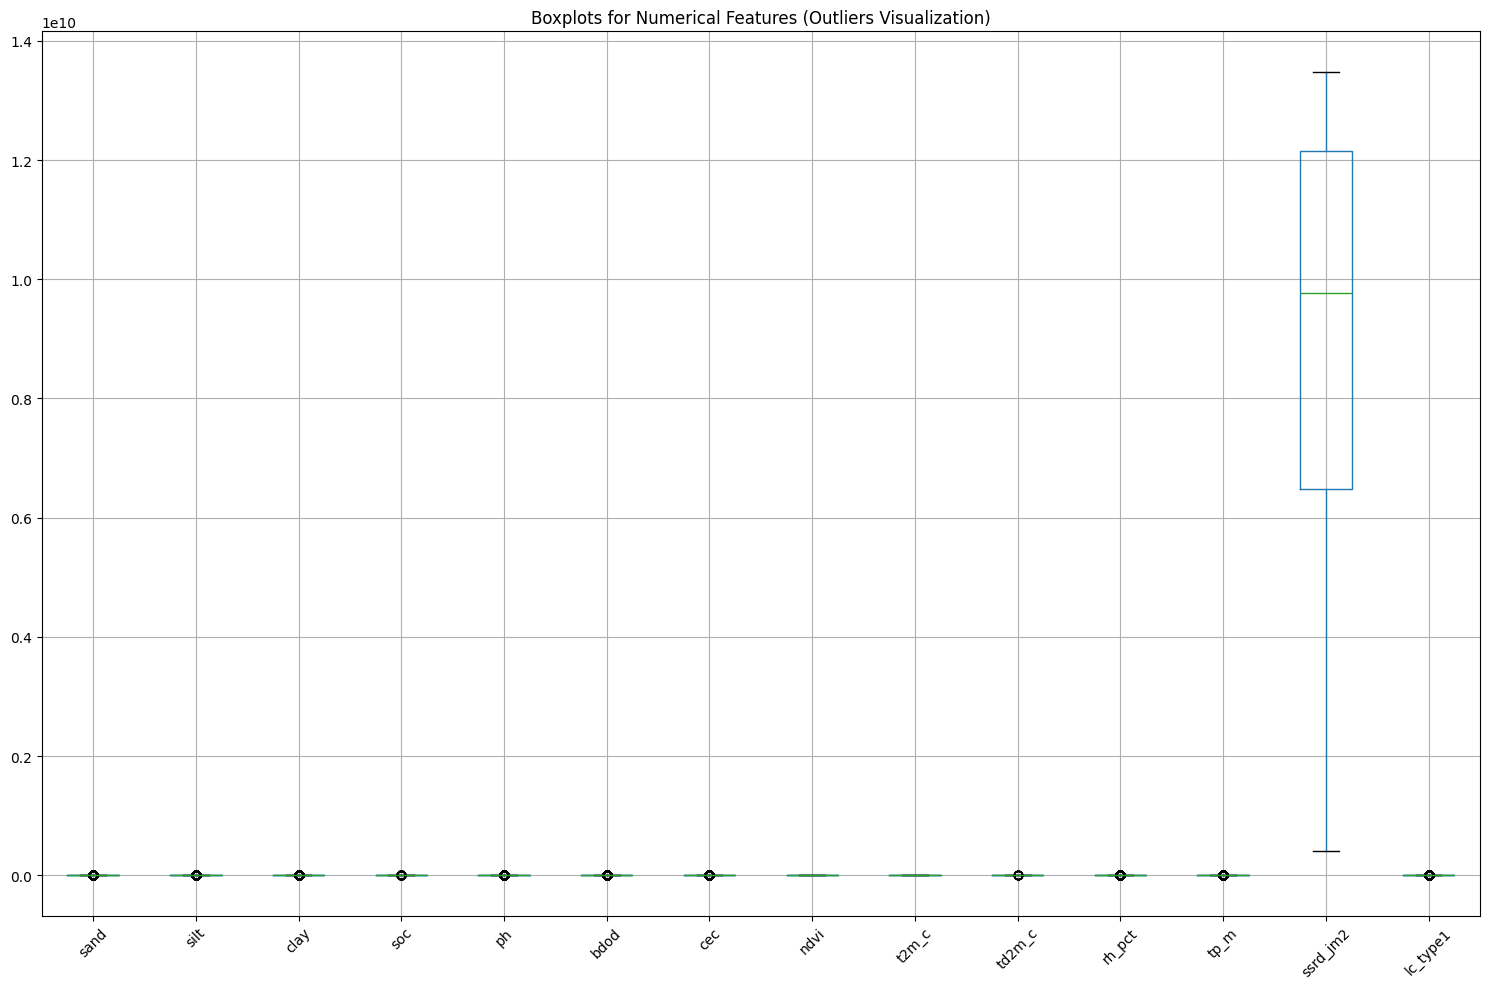

In [12]:
plt.figure(figsize=(15, 10))
df[numeric_cols].boxplot(rot=45)
plt.title("Boxplots for Numerical Features (Outliers Visualization)")
plt.tight_layout()
plt.show()

In [13]:
df.head(5).T

,0,1,2,3,4
sand,41.9,41.9,41.9,41.9,41.9
silt,32.6,32.6,32.6,32.6,32.6
clay,25.4,25.4,25.4,25.4,25.4
soc,36.4,36.4,36.4,36.4,36.4
ph,7.6,7.6,7.6,7.6,7.6
bdod,1.38,1.38,1.38,1.38,1.38
cec,2.14,2.14,2.14,2.14,2.14
ndvi,0.2349,0.25945,0.26755,0.23695,0.22175
t2m_c,13.499527,14.102349,16.424418,18.48001,22.038071
td2m_c,6.782051,7.990648,9.963948,11.995997,15.278302


In [14]:
df.describe()

,sand,silt,clay,soc,ph,bdod,cec,ndvi,t2m_c,td2m_c,rh_pct,tp_m,ssrd_jm2,lc_type1
count,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,123999.000000,1.239990e+05,123999.000000
mean,410.967212,265.766631,299.772654,286.648553,74.187100,129.372421,176.186840,0.413166,22.595355,10.881446,48.653923,0.026975,9.427551e+09,45.475205
std,92.354598,57.265192,62.836355,160.485556,11.479854,21.829665,35.439703,0.211447,5.810962,4.738557,9.759863,0.043793,2.726709e+09,11.538169
min,34.700000,18.900000,17.900000,3.400000,7.100000,1.160000,1.280000,-0.114550,5.750651,-8.271046,12.078892,0.000124,4.024294e+08,10.000000
25%,363.000000,245.000000,268.000000,149.000000,73.000000,130.000000,166.000000,0.218900,17.542559,6.861911,42.102394,0.001804,6.478251e+09,40.000000
50%,402.000000,276.000000,299.000000,312.000000,75.000000,131.000000,186.000000,0.435800,22.738276,10.500346,49.620983,0.011162,9.761923e+09,40.000000
75%,471.000000,294.000000,345.000000,400.000000,79.000000,134.000000,194.000000,0.584650,28.116304,14.849731,55.768063,0.036230,1.215463e+10,50.000000
max,581.000000,425.000000,444.000000,821.000000,82.000000,150.000000,321.000000,0.884100,36.818349,22.776524,74.876660,1.476946,1.348570e+10,90.000000


In [15]:
le = LabelEncoder()
df['des_level_encoded'] = le.fit_transform(df['des_level'])

In [16]:
X = df.drop(columns=['des_level','des_level_encoded'], axis=1)
y = df['des_level_encoded']

In [17]:
# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = ['lc_type1']  # treat lc_type1 as categorical
if 'lc_type1' in numeric_cols:
    numeric_cols.remove('lc_type1')

In [18]:
expected_features = X.columns.tolist()
joblib.dump(expected_features, "feature_names.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
class FeatureFilter(BaseEstimator, TransformerMixin):
    def __init__(self, expected_features):
        self.expected_features = expected_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X = X[[c for c in self.expected_features if c in X.columns]]

        for c in self.expected_features:
            if c not in X.columns:
                X[c] = np.nan

        return X[self.expected_features]

In [21]:
# Preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [22]:
# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('feature_filter', FeatureFilter(expected_features)),
    ('preprocessing', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        class_weight='balanced'
    ))
])

In [23]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_filter',
                 FeatureFilter(expected_features=['sand', 'silt', 'clay', 'soc',
                                                  'ph', 'bdod', 'cec', 'ndvi',
                                                  't2m_c', 'td2m_c', 'rh_pct',
                                                  'tp_m', 'ssrd_jm2',
                                                  'lc_type1'])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sand', 'silt', 'clay',
                                                   'soc', 'ph', 'bdod', 'cec',
                                                   'ndvi', 't2m_c', 'td2m_c',
                                                   'rh_pct', 'tp_m',
                                                   'ssrd_jm2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['lc_type1'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=300, random_state=42))])

In [24]:
y_pred = rf_pipeline.predict(X_test)

In [25]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9681451612903226

Report:
               precision    recall  f1-score   support

        High       0.98      0.98      0.98     13193
         Low       0.78      0.99      0.87       733
      Medium       0.97      0.96      0.96     10874

    accuracy                           0.97     24800
   macro avg       0.91      0.97      0.94     24800
weighted avg       0.97      0.97      0.97     24800



In [26]:
#joblib.dump(rf_pipeline, "rf_desertification_pipeline.pkl")

In [27]:
'''xgb_pipeline = Pipeline([
    ('feature_filter', FeatureFilter(expected_features)),
    ('preprocessing', preprocess),
    ('model', XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    ))
])'''

"xgb_pipeline = Pipeline([\n    ('feature_filter', FeatureFilter(expected_features)),\n    ('preprocessing', preprocess),\n    ('model', XGBClassifier(\n        n_estimators=200,\n        max_depth=4,\n        learning_rate=0.05,\n        subsample=0.8,\n        colsample_bytree=0.8,\n        min_child_weight=3,\n        gamma=0.1,\n        reg_alpha=0.1,\n        reg_lambda=1.0,\n        objective='multi:softprob',\n        eval_metric='mlogloss',\n        random_state=42,\n        n_jobs=-1\n    ))\n])"

In [28]:
xgb_pipeline = Pipeline([
    ('feature_filter', FeatureFilter(expected_features)),
    ('preprocessing', preprocess),
    ('model', XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_weight=5,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    ))
])

In [29]:
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)

In [30]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9746774193548388

Report:
               precision    recall  f1-score   support

        High       0.98      0.98      0.98     13193
         Low       0.94      0.86      0.90       733
      Medium       0.97      0.97      0.97     10874

    accuracy                           0.97     24800
   macro avg       0.96      0.94      0.95     24800
weighted avg       0.97      0.97      0.97     24800



In [31]:
print("Train acc:", accuracy_score(y_train, xgb_pipeline.predict(X_train)))
print("Test acc:", accuracy_score(y_test, y_pred))

Train acc: 0.9748485367796046
Test acc: 0.9746774193548388


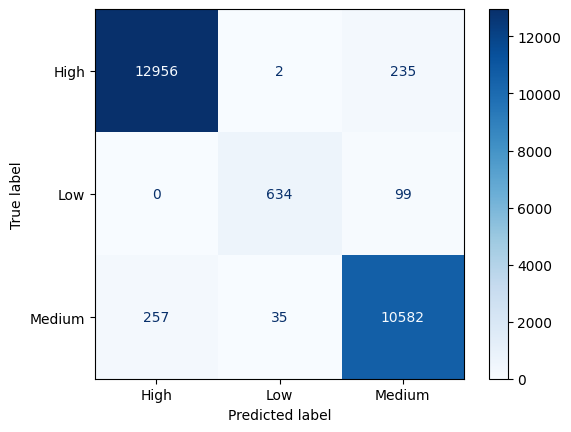

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')

In [33]:
scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='accuracy')
print("CV Accuracy scores:", scores)
print("Mean CV Accuracy:", scores.mean())

CV Accuracy scores: [0.85116935 0.93943548 0.94516129 0.95149194 0.86765595]
Mean CV Accuracy: 0.9109828036770473


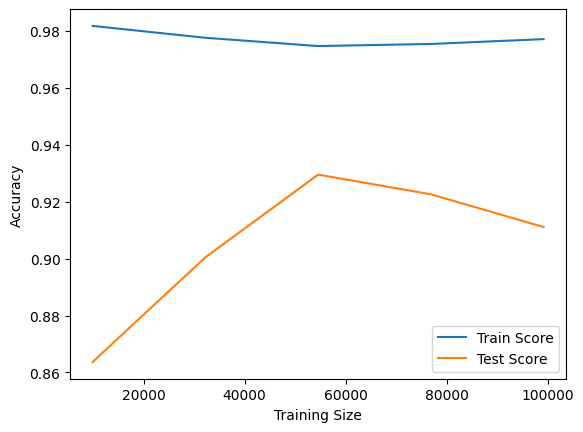

In [34]:
train_sizes, train_scores, test_scores = learning_curve(xgb_pipeline, X, y, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
joblib.dump(xgb_pipeline, "xgb_desertification_pipeline.pkl")

['xgb_desertification_pipeline.pkl']

In [36]:
# Load pipeline & artifacts
xgb_pipe = joblib.load("xgb_desertification_pipeline.pkl")
le = joblib.load("label_encoder.pkl")
expected_features = joblib.load("feature_names.pkl")

api_features = {
    "year": 2025,
    "month": 12,
    "sand": 549,
    "silt": 134,
    "clay": 317,
    "soc": 68,
    "ph": 81,
    "bdod": 1290,
    "cec": 152,
    "ndvi": 0.091,
    "t2m_c": 19.33,
    "td2m_c": -3.5502557593538766,
    "rh_pct": 21,
    "tp_m": 0,
    "ssrd_jm2": 2940000.0000000005,
    "lc_type1": 60,
    "lc_source": "ESA_WorldCover_v100_2020",
    "nitrogen": 0.062,
    "phosphorus": 14.1,
    "potassium": 115,
    "latitude": 28.5,
    "longitude": 29.2
}

api_df = pd.DataFrame([api_features])

api_df = api_df[expected_features]

# Predict
pred_encoded = xgb_pipe.predict(api_df)
pred_label = le.inverse_transform(pred_encoded)
pred_proba = xgb_pipe.predict_proba(api_df).max(axis=1)

print("Predicted Desertification Level:", pred_label[0])
print("Prediction Confidence:", pred_proba[0])

Predicted Desertification Level: High
Prediction Confidence: 0.9977697
